<a href="https://colab.research.google.com/github/jegraham/1-GNN-KMeans/blob/main/Simplified_Graham%2C_Jessica_GAE_Clustering_Phase_1_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple K-Means GAE Implementation (Step 1)

This is the initial GAE implementation using encoders and decoders. Parameters can be modified under the 'Testing Parameters' Section and will be implemented throughout the code.

## Import

### Import Libraries

In [ ]:
import os
import os.path as osp
import shutil # -> For copying a directory
import pandas as pd # -> For data structure and file manipulation
import random
import datetime

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [ ]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html


from collections import Counter
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from scipy import stats
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, FeatureAgglomeration, SpectralClustering, MiniBatchKMeans, Birch, DBSCAN, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE, GINConv, GATConv
from torch_geometric.utils import train_test_split_edges, from_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit, RemoveDuplicatedEdges
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, from_networkx


2.0.1+cu118
Using cpu.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


### Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [ ]:
# Import the Data
from google.colab import files
#uploaded = files.upload()
#uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

#file_name = next(iter(uploaded))

file_name = 'May 4th Dataset Car and Tower  - Sheet1.csv'
print(file_name)
df = pd.read_csv(file_name)
df = df.reset_index(drop=True)

print(df.head())

May 4th Dataset Car and Tower  - Sheet1.csv
  Car ID       X       Y
0  RSU 1   900.0   900.0
1  RSU 2  3300.0   900.0
2  RSU 3   900.0  2500.0
3  RSU 4  3300.0  2500.0
4  RSU 5  1600.0  1600.0


## Testing Parameters

In [ ]:
# Define the root directory where the dataset will be stored
root = './'
version = 'v1'
run_id = 'gnn_1000_k_40_dist_100_transform'

# File Path
folder_path = f'./results/{run_id}_{version}/'
os.makedirs(folder_path, exist_ok=True)


# Define the Number of Clusters
num_clusters = 40
clusters = []

max_dist_tower = 500
max_dist = 170

# Channel Parameters & GAE MODEL
in_channels = 3
hidden_channels = 5
out_channels = 5

# Transform Parameters
transform_set = True #if features needed to be normalized

# Optimizer Parameters (learning rate)
learn_rate = 0.001

# Epochs or the number of generation/iterations of the training dataset
# epoch and n_init refers to the number of times the clustering algorithm will run different initializations
epochs = 4000

# Setting up Colours for the test visualizations
colours_simp = ['blue', 'green', 'purple', 'cyan', 'brown', 'magenta', 'teal','turquoise','coral','indigo', 'gold']
colors_full = ["black" if c <= -1 else "blue" if c == 0 else "green" if c == 1 else "purple" if c == 2 else "cyan" if c == 3 else "brown" if c == 4 else "magenta" if c == 5 else "teal" if c == 6 else "turquoise" if c == 7 else "coral" if c == 8 else "indigo" if c == 9 else "gold" if c == 10 else "grey" for c in clusters]
# Start Session Time
start_time = datetime.datetime.now()

# Run GNN

## InMemory Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [ ]:
#InMemoryDataset
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name
        super().__init__(root, transform, pre_transform)
        ## if the data exists in the processed dir, then it loads directly from there, if not, it will run process
        self.data = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        #get the data from the original folder and save it to the raw folder
        from_path = os.path.join(self.root, self.filename)
        to_path = dest = os.path.join(self.raw_dir, self.filename)
        df = pd.read_csv(from_path)
        df.reset_index(drop=True)
        df.to_csv(to_path,index=False)

    def read_file(self):
        #read file from raw folder, and clean it
        path = osp.join(self.raw_dir, self.filename)
        df = pd.read_csv(path)
        df = df.reset_index(drop=True)

        # Set the RSU and Tower to represent Infrastructure = 1, Car = 0|
        df['Type'] = np.where((df['Car ID'].str.contains('Tower')), 1, 0)
        df = df.drop(columns=['Car ID'])
        return df

    def process(self):
        #read the file and transform it into a pytorch geometric Data
        df = self.read_file()
        df = df.reset_index(drop=True)

        edge_source = []
        edge_target = []

        # Loop row by row to add the edges to the graph
        for i in range(0, len(df)):
            # Inner loop to iterate through all other vehicles
            for j in range(i+1, len(df)):
                  if i != j:
                    dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

                    if (df.iloc[i] == 1).any() or (df.iloc[j] == 1).any():  ##tower
                      # Distance between anything and the Car/Tower/RSU in question
                      #tower to car, tower to tower
                      if 0 < dist <= max_dist_tower:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)
                    else :
                      if 0 < dist <= max_dist:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)

        # Create PyTorch Geometric Data object
        data = Data(
            x=torch.tensor(df.values, dtype=torch.float),
            edge_index=torch.tensor([edge_source, edge_target], dtype=torch.long)
        )
        torch.save(data, self.processed_paths[0])

## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_ = MyDataset(root,file_name)

if transform_set:
  dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
else:
  dataset = MyDataset(root,file_name)


data = dataset[0]
data_ = dataset_[0]

transform = RemoveDuplicatedEdges()
data = transform(data)
data_ = transform(data_)

transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.15,
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=True)

train_data, val_data, test_data = transform(data)

# Display Graphs
print(f'Number of graphs: {len(dataset)}')
print('dataset',dataset) ## dataset is vector with size 1 because we have one graph

print(f'Number of features: {dataset.num_features}')
print('------------')

# Print information for initialization
print('data', data) ## in the entire graph
print('train data',train_data)
print('valid data', val_data)
print('test data', test_data)
print('------------')

print(data.is_directed())

# Create adjacency matrix --- Likely remove
#A = {}
#edge_index = train_data.edge_index
#for i in range(edge_index.shape[1]):
#    src = edge_index[0, i].item()
#    tgt = edge_index[1, i].item()
#    if src not in A:
#        A[src] = []
#    A[src].append(tgt)
#print('adjacency matrix:', A)


Number of graphs: 1
dataset MyDataset()
Number of features: 3
------------
data Data(x=[311, 3], edge_index=[2, 1568])
train data Data(x=[311, 3], edge_index=[2, 1256], pos_edge_label=[628], pos_edge_label_index=[2, 628], neg_edge_label=[628], neg_edge_label_index=[2, 628])
valid data Data(x=[311, 3], edge_index=[2, 1256], pos_edge_label=[39], pos_edge_label_index=[2, 39], neg_edge_label=[39], neg_edge_label_index=[2, 39])
test data Data(x=[311, 3], edge_index=[2, 1334], pos_edge_label=[117], pos_edge_label_index=[2, 117], neg_edge_label=[117], neg_edge_label_index=[2, 117])
------------
False


## Build Graph for Visualization

### Visualize Entire Data


Data(x=[311, 3], edge_index=[2, 1568])


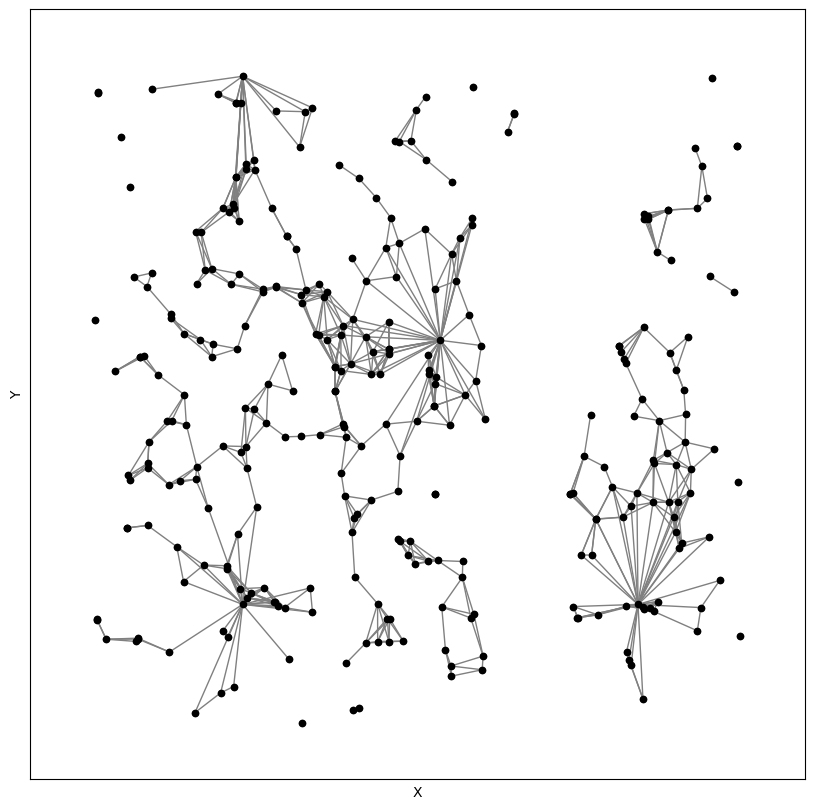

In [ ]:
print(data_)

G = to_networkx(data_)
G = G.to_undirected()

X = data_.x[:,[0,1]].cpu().detach().numpy()
pos = dict(zip(range(X[:, 0].size), X))

## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:,0], X[:,1], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-initial-graph', format='eps', dpi=300)
plt.show()

### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels):
      super(GCNEncoder, self).__init__()

      #GCN
      #self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
      #self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning

      # SAGE
      #self.conv1 = SAGEConv(in_channels, hidden_channels, cached=True) # cached only for transductive learning
      #self.conv2 = SAGEConv(hidden_channels, out_channels, cached=True) # cached only for transductive learning

      # GAT
      self.in_head = 8
      self.out_head = 1
      self.conv1 = GATConv(in_channels, hidden_channels, heads=self.in_head, dropout=0.6)
      self.conv2 = GATConv(hidden_channels*self.in_head, out_channels, concat=False)#, heads=self.out_head, dropout=0.6)


    def forward(self, x, edge_index):
      x = self.conv1(x, edge_index).relu()
      x = F.dropout(x, p=0.6, training=self.training)
      x = self.conv2(x, edge_index)
      return x



### Define the Autoencoder



In [ ]:
# Initialize the model
model = GAE(GCNEncoder(in_channels, hidden_channels, out_channels))

model = model.to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)
data_ = data_.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)
print(model)

GAE(
  (encoder): GCNEncoder(
    (conv1): GATConv(3, 5, heads=8)
    (conv2): GATConv(40, 5, heads=1)
  )
  (decoder): InnerProductDecoder()
)


In [ ]:
def train(dt):
    model.train()
    optimizer.zero_grad()
    #with torch.autograd.detect_anomaly():
    z = model.encode(dt.x, dt.pos_edge_label_index)
    loss = model.recon_loss(z, dt.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(dt):
    model.eval()
    with torch.no_grad():
      z = model.encode(dt.x, dt.pos_edge_label_index)
    return model.test(z, dt.pos_edge_label_index, dt.neg_edge_label_index)


In [ ]:
auc_values = []
ap_values = []

model.reset_parameters()
#torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    loss = train(train_data)

    if (epoch % 100 == 0):
        # Area under Curve (AUC) and Average Precision (AP)
        auc, ap = test(test_data)
        print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
        auc_values.append(auc)
        ap_values.append(ap)

Epoch: 100, Loss: 1.2617, AUC: 0.7526, AP: 0.7530
Epoch: 200, Loss: 1.2247, AUC: 0.7525, AP: 0.7522
Epoch: 300, Loss: 1.2258, AUC: 0.7493, AP: 0.7500
Epoch: 400, Loss: 1.1805, AUC: 0.7508, AP: 0.7525
Epoch: 500, Loss: 1.1665, AUC: 0.7553, AP: 0.7554
Epoch: 600, Loss: 1.1829, AUC: 0.7537, AP: 0.7518
Epoch: 700, Loss: 1.1724, AUC: 0.7543, AP: 0.7527
Epoch: 800, Loss: 1.2179, AUC: 0.7537, AP: 0.7510
Epoch: 900, Loss: 1.1716, AUC: 0.7545, AP: 0.7500
Epoch: 1000, Loss: 1.1712, AUC: 0.7535, AP: 0.7509
Epoch: 1100, Loss: 1.1995, AUC: 0.7565, AP: 0.7503
Epoch: 1200, Loss: 1.1477, AUC: 0.7563, AP: 0.7497
Epoch: 1300, Loss: 1.1618, AUC: 0.7567, AP: 0.7495
Epoch: 1400, Loss: 1.1378, AUC: 0.7570, AP: 0.7507
Epoch: 1500, Loss: 1.1174, AUC: 0.7580, AP: 0.7525
Epoch: 1600, Loss: 1.1704, AUC: 0.7581, AP: 0.7512
Epoch: 1700, Loss: 1.1804, AUC: 0.7593, AP: 0.7522
Epoch: 1800, Loss: 1.0899, AUC: 0.7583, AP: 0.7486
Epoch: 1900, Loss: 1.0990, AUC: 0.7583, AP: 0.7489
Epoch: 2000, Loss: 1.1536, AUC: 0.7591, 

## Embedding

#### Clustering with only (Node) Features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


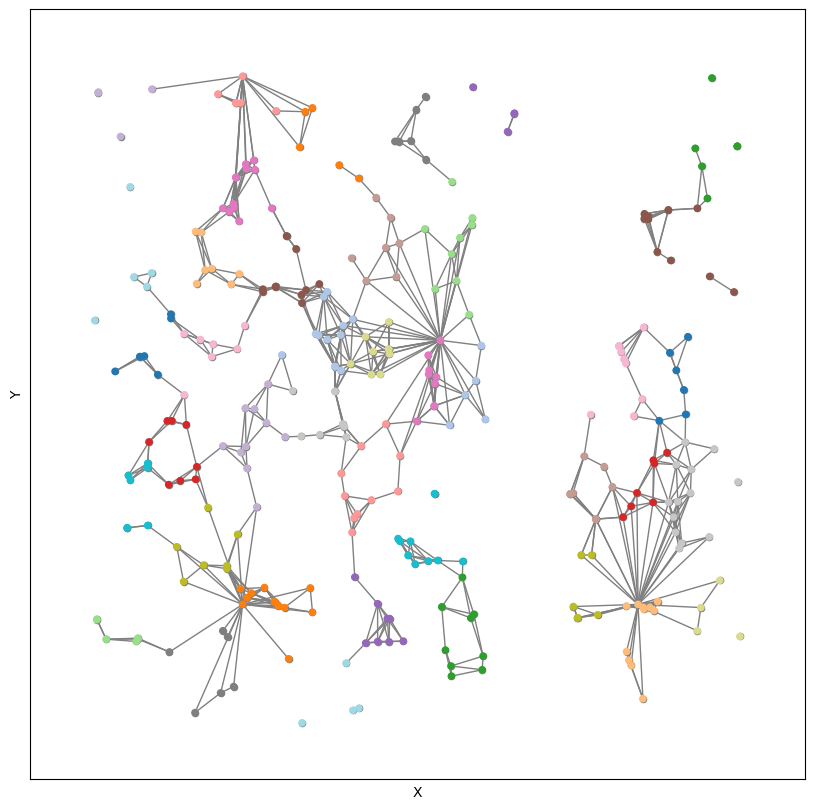

In [ ]:
#------------------------------------------------------------Clustering
kmeans = KMeans(n_clusters=num_clusters)
eval_data = test_data
eval_data = data_
X = eval_data.x[:,[0,1]].cpu().detach().numpy()

df = pd.DataFrame(X, columns = ['X','Y'])
kmeans.fit(df[['X', 'Y']])

# Adding cluster labels to the DataFrame
df_with_cluster = df.copy(deep=True)
df_with_cluster['cluster'] = kmeans.labels_

G = to_networkx(eval_data)
G = G.to_undirected()
node_labels = kmeans.labels_

pos = dict(zip(range(X[:, 0].size), X))

## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:,0], X[:,1], s=20, color='grey')
# nx.draw(G, cmap=plt.get_cmap('Set1'), node_color = node_labels,node_size=75,linewidths=6)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('tab20'), node_color = node_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-node-features-non-gnn', format='eps', dpi=300)
plt.show()

### KMeans Clustering with Graph and Features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


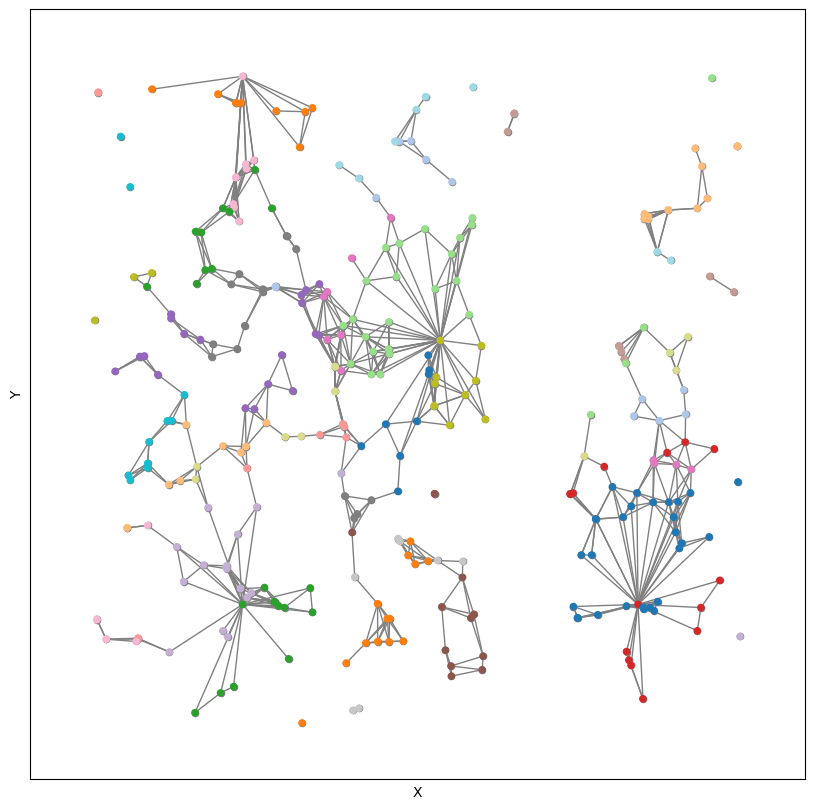

In [ ]:
model.eval()
with torch.no_grad():
  z = model.encode(data_.x, data_.edge_index)

# Perform KMeans clustering on the latent space (z)
kmeans = KMeans(n_clusters=num_clusters).fit(z.cpu().detach().numpy())

eval_data = test_data
eval_data = data_
X = eval_data.x[:,[0,1]].cpu().detach().numpy()

G = to_networkx(eval_data)
G = G.to_undirected()
node_labels = kmeans.labels_

## draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:,0], X[:,1], s=20, color='grey')
# nx.draw(G, cmap=plt.get_cmap('Set1'), node_color = node_labels,node_size=75,linewidths=6)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('tab20'), node_color = node_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-kmeans-cluster-node-features-gnn', format='eps', dpi=300)
plt.show()

# Performance Analysis - GNN

### Save to CSV

In [ ]:
import csv

def save_array_to_csv(r_id, ftype, v, array_data, title_count, title_type, row_title, row_number):
    # Check if the file already exists
    file_exists = os.path.exists(f"{r_id}_{ftype}_{title_type}_{v}.csv")
    file_path = f"{folder_path}{r_id}_{ftype}_{title_type}_{v}.csv"

    try:
        mode = 'a' if os.path.exists(file_path) else 'w'

        # Use 'a' mode (append), w mode to write to open the file
        with open(file_path, mode=mode, newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # If the file doesn't exist, write the titles
            if mode == 'w':
                titles = [f"{row_title}"]  # Replace with your actual column titles

                for i in range(title_count):
                    titles.append(f"{i+1}")

                csv_writer.writerow(titles)

            if isinstance(array_data, list) and all(isinstance(row, list) for row in array_data):
                # Write the data rows
                print("if")
                for row in enumerate(len(array_data[0]), start=1):
                    csv_writer.writerow(array_data[row])
            else:
                print("else")
                row_name = [f"{row_title} {row_number}"]  + array_data
                csv_writer.writerow(row_name)

        print(f"Data successfully saved to {file_path}.")
    except Exception as e:
          print(f"Error occurred while saving data to {file_path}: {e}")


# ###-----------------------------------------------------------------------------------------Call the method and filename here
# # Add the variable name and array name to the file path
# file_type = 'distortions'
# csv_file_path = f"{run_id}_{file_type}_{version}.csv"

# # Call the function to save the array to the CSV file
# save_array_to_csv(distortions, csv_file_path)

### Graph Epoch AUC and AP - Works



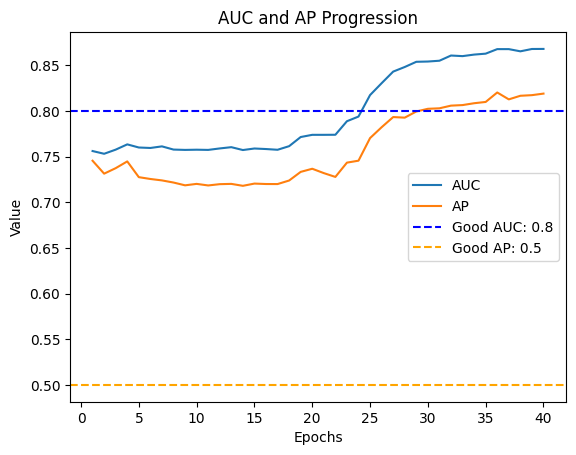

else
Data successfully saved to ./results/gnn_1000_k_40_dist_100_transform_v1/gnn_1000_k_40_dist_100_transform_auc_epoch_v1.csv.
else
Data successfully saved to ./results/gnn_1000_k_40_dist_100_transform_v1/gnn_1000_k_40_dist_100_transform_ap_epoch_v1.csv.


In [ ]:
# Generate x-axis values for the graph (e.g., epochs or any other x-axis values)
x_values = range(1, len(auc_values) + 1)

# Plot AUC values
plt.plot(x_values, auc_values, label='AUC')

# Plot AP values
plt.plot(x_values, ap_values, label='AP')

# Good values for AUC and AP
good_auc = 0.8
good_ap = 0.5

# Plot horizontal lines for good AUC and AP values
plt.axhline(y=good_auc, color='blue', linestyle='dashed', label=f'Good AUC: {good_auc}')
plt.axhline(y=good_ap, color='orange', linestyle='dashed', label=f'Good AP: {good_ap}')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('AUC and AP Progression')

# Display a legend
plt.legend()


# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-auc-ap', format='eps', dpi=300)
# Show the plot
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'auc', version, auc_values, epoch, 'epoch', 'cluster', num_clusters)
save_array_to_csv(run_id, 'ap', version, ap_values, epoch, 'epoch', 'cluster', num_clusters)


### Cluster Graph - Partially Works

In [ ]:
# Find the cluster head indices
cluster_head_indices = []
for i in range(num_clusters):
    # Get the indices of data points belonging to the current cluster
    cluster_indices = [idx for idx, cluster_label in enumerate(kmeans.labels_) if cluster_label == i]
    # Calculate the distance of each data point in the cluster to its cluster center
    distances_to_center = np.linalg.norm(np.array(x_y_array)[cluster_indices] - cluster_centers[i], axis=1)
    # Find the index of the data point with minimum distance (the cluster head index)
    cluster_head_index = cluster_indices[np.argmin(distances_to_center)]
    cluster_head_indices.append(cluster_head_index)


# Plot Graph with Clusters, Cluster Centers, and Cluster Heads
plt.figure(figsize=(8, 8))
pos = {}
for i in range(G.number_of_nodes()):
    pos[i] = (x_y_array[i][0], x_y_array[i][1])

# Define the color map for clusters
color_map = plt.cm.get_cmap('tab20', num_clusters)

# Iterate through nodes and highlight RSU nodes with yellow
for i, node in enumerate(G.nodes()):
    if 'RSU' in G.nodes[node]:
        nx.draw_networkx_nodes(G, pos, [node], node_size=600, node_color='yellow')
    else:
        cluster = clusters[i]
        color = 'grey' if cluster in range(num_clusters, num_clusters+5) else color_map(cluster)
        nx.draw_networkx_nodes(G, pos, [node], node_size=60, node_color=color)

# Draw cluster centers with 'X' marker
cluster_x, cluster_y = zip(*cluster_centers)
plt.scatter(cluster_x, cluster_y, marker='x', s=100, c='black', label='Cluster Centers')

# Draw cluster heads with 'D' marker (Diamond marker)
cluster_head_x = [x_y_array[i][0] for i in cluster_head_indices]
cluster_head_y = [x_y_array[i][1] for i in cluster_head_indices]
plt.scatter(cluster_head_x, cluster_head_y, marker='D', s=200, c='black', edgecolors='white', linewidth=1, label='Cluster Heads')

nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}_cluster_graph.eps', format='eps', dpi=300)

plt.show()

NameError: ignored

### Generate Multiple Clusters
Elbow for non-GNN - SSE (aka distortions) - Works

In [ ]:
# Loop over different cluster sizes
sse_values = []
num_clusters_range = range(1, num_clusters + 1)
min_cluster_sizes = []
max_cluster_sizes = []
median_cluster_sizes = []
# distances_to_centerhead = np.linalg.norm(x_y_array - cluster_centers[kmeans.labels_], axis=1)
avg_cluster_distances = []
centroid_avg_distances = []
avg_cluster_densities = []


for num_clusters in K:
    print(f"cluster {num_clusters}")
    # Fit the KMeans model with the given number of clusters
    kmeans = KMeans(n_clusters=num_clusters, n_init=n).fit(x_y_array)
    kmeans.fit(x_y_array)

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    cluster_sizes = dict(Counter(kmeans.labels_))

    # Calculate SSE for the current cluster size
    sse = kmeans.inertia_
    sse_values.append(sse)

    # Calculate the minimum, maximum, and median cluster sizes
    min_cluster_size = min(cluster_sizes.values())
    max_cluster_size = max(cluster_sizes.values())
    median_cluster_size = np.median(list(cluster_sizes.values()))

    # Save the cluster size statistics
    min_cluster_sizes.append(min_cluster_size)
    max_cluster_sizes.append(max_cluster_size)
    median_cluster_sizes.append(median_cluster_size)


    # Calculate the distances between each data point and its cluster center
    distances_to_centerhead = np.linalg.norm(x_y_array - cluster_centers[kmeans.labels_], axis=1)
    cluster_node_avg_distances = []

    # Loop over each cluster
    for cluster in range(num_clusters):
        cluster_mask = kmeans.labels_ == cluster
        cluster_distances = distances_to_centerhead[cluster_mask]
        cluster_node_avg_distance = np.mean(cluster_distances)
        cluster_node_avg_distances.append(cluster_node_avg_distance)

    # Calculate the average cluster distance for the current cluster size
    avg_cluster_distance = np.mean(cluster_node_avg_distances)
    avg_cluster_distances.append(avg_cluster_distance)

    # Calculate the average cluster density for the current cluster size
    avg_cluster_density = len(x_y_array)/ sum(cluster_node_avg_distances)
    avg_cluster_densities.append(avg_cluster_density)

    min_list = []
    for i in range(num_clusters):
        min_dist = float('inf')
        total = []
        for j in range(len(rsu_list)):
            dist = math.sqrt((rsu_list[j][1] - cluster_centers[i][0])**2 + (rsu_list[j][2] - cluster_centers[i][1])**2)
            if dist < min_dist:
              min_dist = dist
        min_list.append(min_dist)

    centroid_min_avg_distance = np.mean(min_list)
    centroid_avg_distances.append(centroid_min_avg_distance)

    # Calculate distances from data points to their respective cluster centers------------------------
    distances_to_centers = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        cluster_idx = cluster_labels[i]
        distance = np.linalg.norm(X[i] - cluster_centers[cluster_idx])
        distances_to_centers[i] = distance

    # Sort the distances in ascending order
    sorted_distances = np.sort(distances_to_centers)

    # Compute the cumulative probabilities for each distance
    cumulative_probabilities = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)

    # Fit a continuous distribution to the distances and obtain the CDF values for the fitted distribution
    fitted_distribution = stats.rv_histogram(np.histogram(sorted_distances, bins=20))
    cdf_fitted = fitted_distribution.cdf(sorted_distances)

    # Plot the CDF curve for the current cluster size as a smooth line
    ax.plot(sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}') #----------------------------

    # Get the sizes of each cluster
    # cluster_sizes = [np.sum(kmeans.labels_ == i) for i in range(num_clusters)]



### SSE (elbow) - Works

In [ ]:
# Plot the SSE and distortion curves
plt.plot(K, sse_values, marker='o', linestyle='-', label='SSE')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-sse-elbow', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'non-gnn-sse-elbow', version, sse_values, num_clusters, 'cluster', 'cluster', 's')

### Max, Min, Median Clusters (elbow) - works

In [ ]:
# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, min_cluster_sizes, marker='o', linestyle='-', label='Min Size')
plt.plot(num_clusters_range, max_cluster_sizes, marker='o', linestyle='-', label='Max Size')
plt.plot(num_clusters_range, median_cluster_sizes, marker='o', linestyle='-', label='Median Size')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Different Numbers of Clusters')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-min-max-median', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'max', version, min_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'min', version, max_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'median', version, median_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)

### Avg Distance per Cluster to Centroid (elbow) - Works

In [ ]:
# Plot the graph as a line plot
plt.plot(num_clusters_range, avg_cluster_distances, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size')
plt.savefig(f'{folder_path}{run_id}_{version}-avg_dist_to_centroid', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_dist_to_centroid', version, avg_cluster_distances, num_clusters, 'cluster', 'epoch', epoch)

### Centroid to Nearest RSU - Works

In [ ]:
# Plot the graph as a line plot
plt.plot(num_clusters_range, centroid_avg_distances, marker='o', linestyle='-')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size')
plt.savefig(f'{folder_path}{run_id}_{version}-avg_min_dist_to_rsu_to_centroid', format='eps', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_min_dist_rsu_to_centroid', version, centroid_avg_distances, num_clusters, 'cluster', 'epoch', epoch)


### Cluster Densities (elbow) - Works

In [ ]:
# Plot the graph as a line plot
plt.plot(num_clusters_range, avg_cluster_densities, marker='o', linestyle='-')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities')
plt.savefig(f'{folder_path}{run_id}_{version}-avg_cluster_densities', format='eps', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'avg_cluster_densities', version, avg_cluster_densities, num_clusters, 'cluster', 'epoch', epoch)


### CDF - Works

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the CDF curve for the current cluster size as a smooth line
ax.plot(sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}')

# Plot settings
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size)')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-cluster-centroid-distance', format='eps', dpi=300)
plt.show()


In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Fit continuous distributions to the max, min, and median cluster sizes
max_dist = stats.rv_histogram(np.histogram(max_cluster_sizes, bins=20))
min_dist = stats.rv_histogram(np.histogram(min_cluster_sizes, bins=20))
median_dist = stats.rv_histogram(np.histogram(median_cluster_sizes, bins=20))

# Calculate CDF values for each distribution
max_cdf = max_dist.cdf(max_cluster_sizes)
min_cdf = min_dist.cdf(min_cluster_sizes)
median_cdf = median_dist.cdf(median_cluster_sizes)

# Plot the CDF curves for max, min, and median cluster sizes
ax.plot(max_cluster_sizes, max_cdf, label='Max Cluster Size', linestyle='-', marker='o')
ax.plot(min_cluster_sizes, min_cdf, label='Min Cluster Size', linestyle='-', marker='x')
ax.plot(median_cluster_sizes, median_cdf, label='Median Cluster Size', linestyle='-', marker='s')

# Plot settings
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max, Min, and Median Cluster Sizes')
ax.legend()
ax.grid(True)

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-max-min-median', format='eps', dpi=300)

plt.show()

In [ ]:
# Sort the values for plotting the CDF
sorted_auc_values = np.sort(auc_values)
sorted_ap_values = np.sort(ap_values)

# Calculate the cumulative probabilities for the CDF
cdf_auc = np.arange(1, len(sorted_auc_values) + 1) / len(sorted_auc_values)
cdf_ap = np.arange(1, len(sorted_ap_values) + 1) / len(sorted_ap_values)

# Plot the CDF for AUC
plt.plot(sorted_auc_values, cdf_auc, linestyle='-')
plt.xlabel('AUC Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AUC')
plt.grid(True)

# Add a vertical line at AP = 0.5
plt.axvline(x=0.8, color='red', linestyle='--', label='AUC >= 0.5')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-auc', format='eps', dpi=300)

plt.show()

# Plot the CDF for AP
plt.plot(sorted_ap_values, cdf_ap, linestyle='-')
plt.xlabel('AP Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AP')
plt.grid(True)

# Add a vertical line at AP = 0.5
plt.axvline(x=0.5, color='red', linestyle='--', label='AP >= 0.5')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-cdf-ap', format='eps', dpi=300)

plt.show()

### Truth Tables - NOT WORKING

In [ ]:

# Generate synthetic data for clustering
np.random.seed(0)
X = np.random.rand(100, 2)

# Perform k-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a truth table based on proximity to cluster centers
truth_table = np.zeros((len(X), num_clusters), dtype=int)
for i, data_point in enumerate(X):
    closest_cluster = np.argmin(np.linalg.norm(data_point - cluster_centers, axis=1))
    truth_table[i, closest_cluster] = 1

# Visualize the clustering results using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, label='Data Points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.show()

# Print the truth table
print("Truth Table:")
print(truth_table)

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init = n)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Get cluster head indices (replace this with your own logic to find the cluster head indices)
# For demonstration, we will use the first data point of each cluster as the cluster head
cluster_head_indices = [np.where(labels == i)[0][0] for i in range(num_clusters)]

# Create a scatter plot to visualize the clusters, cluster centers, and cluster heads
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, label='Data Points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.scatter(X[cluster_head_indices, 0], X[cluster_head_indices, 1], c='blue', marker='D', s=100, label='Cluster Heads')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering with Cluster Centers and Cluster Heads')
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=n)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Calculate the distance between each data point and cluster center
distances = cdist(X, cluster_centers, 'euclidean')

# Assign data points to the cluster with the nearest cluster center
assigned_clusters = np.argmin(distances, axis=1)

# Create a ground truth table as a pandas DataFrame
ground_truth_table = pd.DataFrame({
    'Data Point Index': np.arange(len(X)),
    'Assigned Cluster': assigned_clusters
})

print("Ground Truth Table:")
print(ground_truth_table)

In [ ]:

# Generate random data for demonstration
x_y_array = []
K = range(1, num_clusters + 1)

for i in range(G.number_of_nodes()):
    x_y_array.append([G.nodes.data('x')[i], G.nodes.data('y')[i]])

# Run K-means clustering on the x-y matrix
kmeans = KMeans(n_clusters=num_clusters, n_init=n)
kmeans.fit(x_y_array)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Get the cluster head indices (replace this with your own logic to find the cluster head index)
# For demonstration, let's assume the first data point in each cluster is the cluster head
cluster_head_indices = [np.argwhere(kmeans.labels_ == i)[0][0] for i in range(num_clusters)]

# Calculate the distance from each data point to its corresponding cluster head
distances_to_cluster_heads = np.linalg.norm(x_y_array - cluster_centers[kmeans.labels_], axis=1)

# Create ground truth labels based on distance threshold (e.g., 100 units)
ground_truth_labels = [1 if dist > 100 else 0 for dist in distances_to_cluster_heads]

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Plot Graph with Clusters, Cluster Centers, and Cluster Heads
plt.figure(figsize=(8, 8))
pos = {}
for i in range(G.number_of_nodes()):
    pos[i] = (x_y_array[i][0], x_y_array[i][1])

for i, cluster in enumerate(clusters):
    color = 'grey' if i in range(6) else 'grey' if i in range(6, 10) else plt.cm.Set1(cluster)  # RSU's black, Towers grey
    nx.draw_networkx_nodes(G, pos, [i], node_size=60, node_color=color)

# Draw cluster centers with 'X' marker
cluster_x, cluster_y = zip(*cluster_centers)
plt.scatter(cluster_x, cluster_y, marker='x', s=100, c='red', label='Cluster Centers')

# Draw cluster heads with 'D' marker (Diamond marker)
cluster_head_x = [x_y_array[i][0] for i in cluster_head_indices]
cluster_head_y = [x_y_array[i][1] for i in cluster_head_indices]
plt.scatter(cluster_head_x, cluster_head_y, marker='D', s=100, c='yellow', label='Cluster Heads')

nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.legend()
plt.show()


## Testing Analysis

In [ ]:
def save_parameter_to_txt(param_name, parameter, file_path):
    try:
        with open(file_path, mode='a') as params_file:
            params_file.write(param_name + ':' + str(parameter) + "\n")
    except Exception as e:
        print(f"Error occurred while saving {param_name} parameter to {file_path}: {e}")


In [ ]:
# Print information
print('Test Parameters')
save_parameter_to_txt('Originating Filename',file_name, f"{run_id}_{version}")

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('Number of Clusters ', num_clusters)
save_parameter_to_txt('Number of Clusters ',num_clusters, f"{run_id}_{version}")
print('Number of Initializations of Cluster',n)
save_parameter_to_txt('Number of Initializations of Cluster', n, f"{run_id}_{version}")
print('Max Distance',  max_dist)
save_parameter_to_txt('Max Distance ',max_dist, f"{run_id}_{version}")
print('Transform Set',transform_set)
save_parameter_to_txt('Transform Set', transform_set, f"{run_id}_{version}")
print('Transform Value Number',value_num)
save_parameter_to_txt('Transform Value Number', value_num, f"{run_id}_{version}")
print('Transform Test Number',test_num)
save_parameter_to_txt('Transform Test Number', test_num, f"{run_id}_{version}")
print('Learning Rate',learn_rate)
save_parameter_to_txt('Learning Rate', learn_rate, f"{run_id}_{version}")
print('Epochs/Generations of Training',epochs)
save_parameter_to_txt('Epochs/Generations of Training', epochs, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
# print('Device Details', device, 'Memory',virtual_memory().total / 1e9, 'GB')
# GPU Details
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  save_parameter_to_txt('GPU', 'no', f"{run_id}_{version}")
else:
  print(gpu_info)
  save_parameter_to_txt('GPU', 'yes', f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('dataset',dataset)
save_parameter_to_txt('dataset', dataset, f"{run_id}_{version}")
print('data', data)
save_parameter_to_txt('data', data, f"{run_id}_{version}")
print('train data',train_data)
save_parameter_to_txt('train data', train_data, f"{run_id}_{version}")
print('test data', test_data)
save_parameter_to_txt('test data', test_data, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('Start Time ', start_time)
save_parameter_to_txt('start time', start_time, f"{run_id}_{version}")
print('End Time', end_time)
save_parameter_to_txt('end time', end_time, f"{run_id}_{version}")
duration = end_time - start_time
print('Duration Time', duration)
save_parameter_to_txt('duration', duration, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
save_parameter_to_txt('training positive edges', train_pos_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
test_neg_edge_index = test_data.neg_edge_label_index
print('testing negative edges:', test_neg_edge_index)
save_parameter_to_txt('testing negative edges', test_neg_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
num_graph = len(dataset)
print(f'Number of graphs: {num_graph}')
save_parameter_to_txt('number of graphs', num_graph, f"{run_id}_{version}")
print(f'Number of features: {dataset.num_features}')
save_parameter_to_txt('dataset.num_features', dataset.num_features, f"{run_id}_{version}")
print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")


# FUTURE PARAMETERS
# Density, AVG Distance from Infrastructure, Avg # Hops, Dwell Time, Avg Direction, Avg Signal Strength, Avg Percentage Change/loss





In [ ]:
# Plot the graph with the nodes colored based on the clusters
colors_full = ["black" if c <= -1 else "b" if c == 0 else "g" if c == 1 else "r" if c == 2 else "c" if c == 3 else "m" if c == 4 else "y" if c == 5 else "k" for c in clusters]

nx.draw(G, with_labels=False, node_color=colors_full, node_size=20, width=0.1)
plt.show()

## Download

folder_path = f'./results/{run_id}_{version}/'

In [ ]:

file_path = f'./results/'
shutil.make_archive("./downloads/download_results", 'zip', file_path)

files.download("./downloads/download_results.zip")

In [ ]:
G = nx.Graph()
edge_index = []

# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])

# Create a mapping dictionary to map letters to numerical IDs
letter_to_id = {'RSU 1': 10001, 'RSU 2': 10002, 'RSU 3': 10003,'RSU 4': 10004,'RSU 5': 10005,'RSU 6': 10006,'Tower 1': 100001,'Tower 2': 100002,'Tower 3': 100003,'Tower 4': 100004}

# Replace letters with numerical IDs using the mapping dictionary
df['Car ID'] = df['Car ID'].replace(letter_to_id)


# Find the RSU and Tower Nodes
rsu_tower_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
rsu_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
for i in range(10):
    rsu_tower_list = np.append(rsu_tower_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

for i in range(6):
    rsu_list = np.append(rsu_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'].replace(letter_to_id))

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor

# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= max_dist:
          distances.append((dist, j))
        # print(distance)

        if i != j:
          dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

          if df.iloc[i]['Car ID'] >=10000:  ## Tower and RSU are greater than
             # Distance between (V2I and I2I) the Car/Tower/RSU
             if 0 < dist <= max_dist_tower:
                distances.append((dist, j))
             else :
                if 0 < dist <= max_dist:
                  distances.append((dist, j))


   distances.sort()

   for k in range(len(distances)):
      G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)